In [86]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline 

In [87]:
def f(x):
    return 3*x**2 - 4*x + 5

In [88]:
f(3.0)

20.0

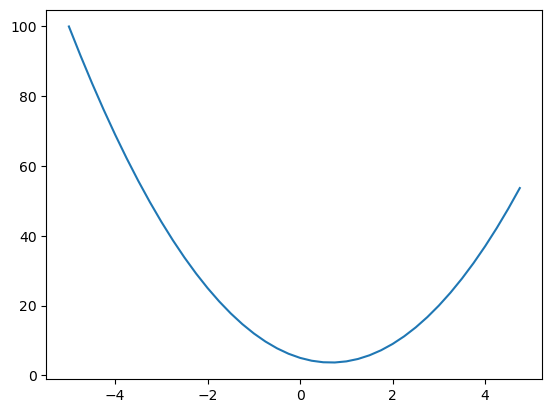

In [89]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [116]:
class Value: 
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) #for efficiency? 
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None 
        
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other) # convert other to Value object if it is not. such as an integer or float
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad # accumulate the gradients instead of adding them 
            # why? in the case of variables being used more than twice, the gradient would then get reset 
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
            
        return out 
    
    def __rmul__(self,other): # fallback in the case of other * self 
        return self * other
    
    def __radd__(self,other): # fallback in the case of other + self 
        return self + other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __pow__(self, other):  # self ^ other 
        assert isinstance(other,(int,float)) 
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) *  out.grad
        
        out._backward = _backward
        return out 
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')
        
        def _backward():
            self.grad +=  out.data * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1 
    
    def __sub__(self,other):
        return self + (-other)
    
    def backward(self):
        topo = [] 
        visited = set ()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [117]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b ; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(2.0, label = 'f')
L = d * f ; L.label = 'L'
L 

Value(data = 8.0)

In [118]:
d.label

'd'

In [119]:
# Visualization code 
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
    
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad) ,shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

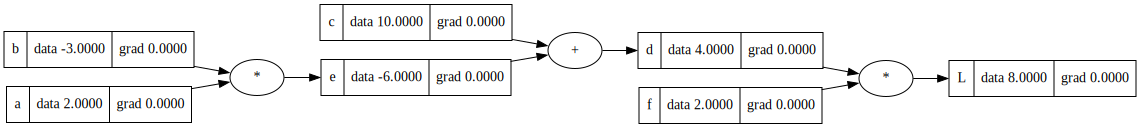

In [120]:
draw_dot(L)

In [121]:
L.grad = 1.0 

In [122]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label ='o'


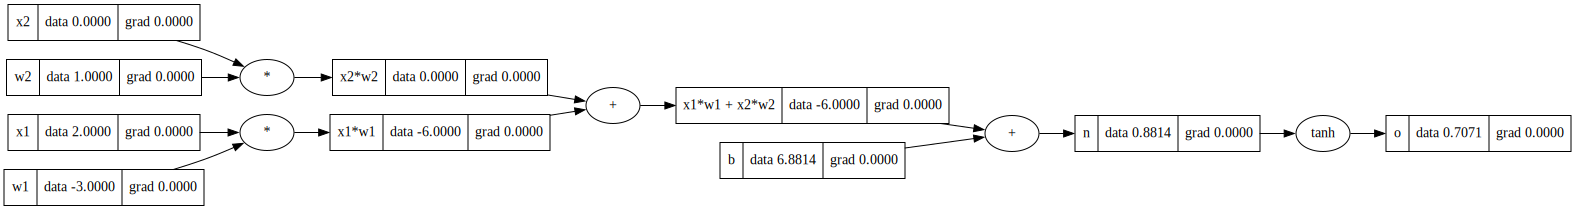

In [123]:
draw_dot(o)


In [124]:
o.backward()

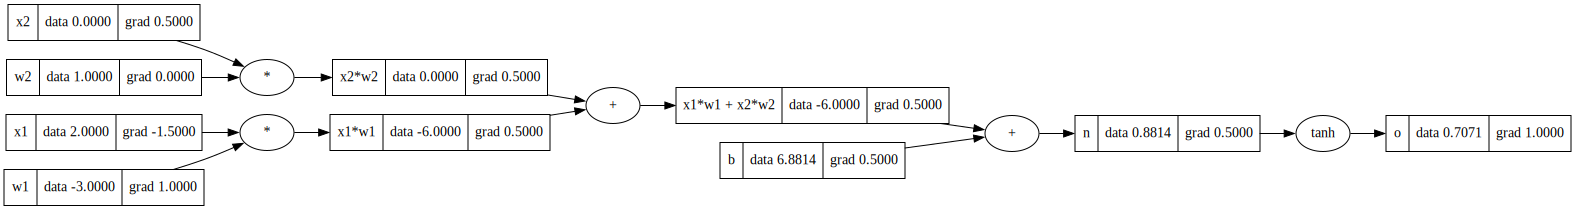

In [125]:
draw_dot(o)


In [126]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data = -2.0)

In [127]:
# Do the same thing but in PyTorch
import torch 

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [128]:
 # building a neural net 
# matching the nn.module API of torch 

In [129]:
class Neuron: 
    
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x): 
        # w * x + b  
        # __call__ is invoked when we use this
        # notation n(x) where n is a Neuron() object
        
        o = zip(self.w, x ) # takes two iterators and combines them into one, pairwise
        act = sum((wi*xi for wi,xi in o), self.b ) # sum() takes additonal arg as a starting point
        # so we start at the bias b 
        
        out = act.tanh()
        return out
    
    def parameters(self): # mimic the parameters method in pytorch to return the parameters 
        return self.w + [self.b] # list + list = list 
    

class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
    
    def parameters(self):
        params = []
        for neuron in self.neurons: 
            ps = neuron.parameters() # the params of the neuron 
            params.extend(ps) # append to the end of the list 
        return params
            

class MLP:
    
    def __init__(self, nin, nouts): # here nouts is a list of nouts 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        # call them sequentially
        for layer in self.layers: 
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
 

In [145]:
# For an MLP of
# 3 input  neurons
# 2 hidden layers with 4 neurons each
# 1 output layer 

x = [2.0, 3,0, -1.0]
n = MLP(3, [4, 4,1]) # 
n(x)   

Value(data = -0.8936511933162903)

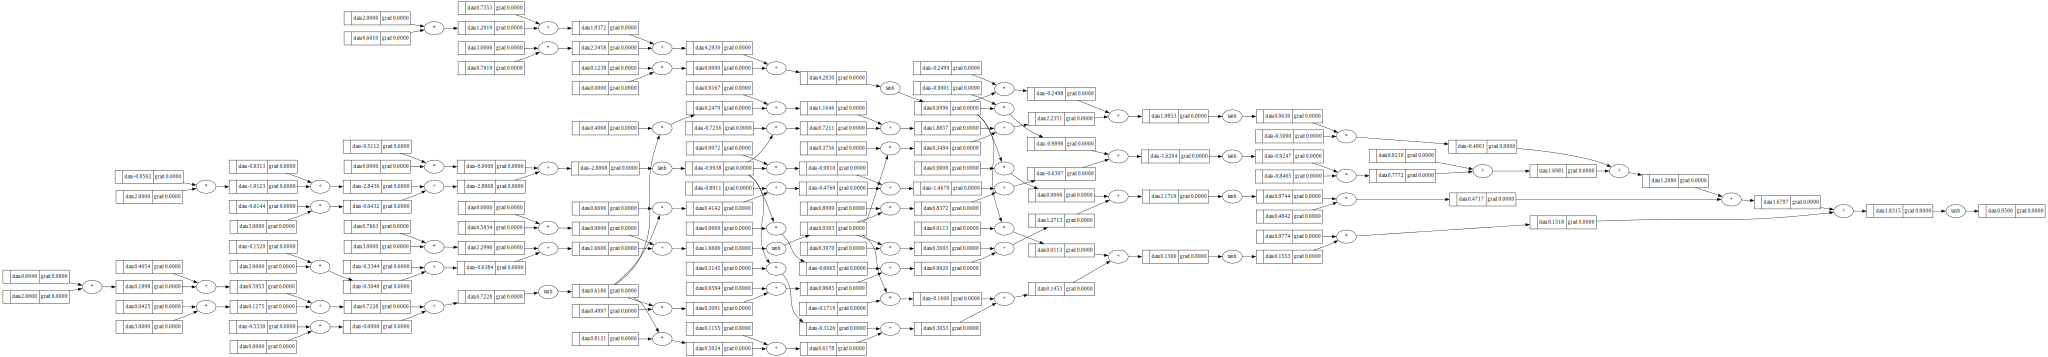

In [131]:
draw_dot(n(x))

In [146]:
# Example dataset 

# Four possible inputs and four desired targets 
# akin to a very simple binary classifier 


xs = [
    [2.0,  3.0, -1.0],
    [3.0, -1.0,  0.5],
    [0.5,  1.0,  1.0],
    [1.0,  1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]


In [153]:
# Training loop

for k in range(20):
    # 1. Forward pass 
    ypred = [n(x) for x in xs]
    # To measure the performance of the network, we define the MSE loss 
    loss = sum ((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    
    # 2. Backward pass
    # 2.1 Set the grad to zero 
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # 3. Update params 
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)
    

0 0.017815309638007336
1 0.017433763061740694
2 0.017067064874775165
3 0.016714390157674272
4 0.016374972985822002
5 0.016048101304096413
6 0.01573311232276603
7 0.015429388374141387
8 0.015136353177366368
9 0.014853468465462361
10 0.014580230934513626
11 0.01431616947986029
12 0.014060842688456551
13 0.013813836560267204
14 0.013574762434795894
15 0.013343255101635781
16 0.013118971076369883
17 0.012901587025273609
18 0.012690798324129851
19 0.012486317738094251


In [154]:
ypred

[Value(data = 0.9541181281754583),
 Value(data = -0.9423057926706936),
 Value(data = -0.9544529106329277),
 Value(data = 0.9294449671050923)]

In [155]:
!pwd

/Users/hardik/repos/neural-networks-deep-dive
